In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-09-29 17:35:44.617888: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-29 17:35:44.618020: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-29 17:35:44.771839: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


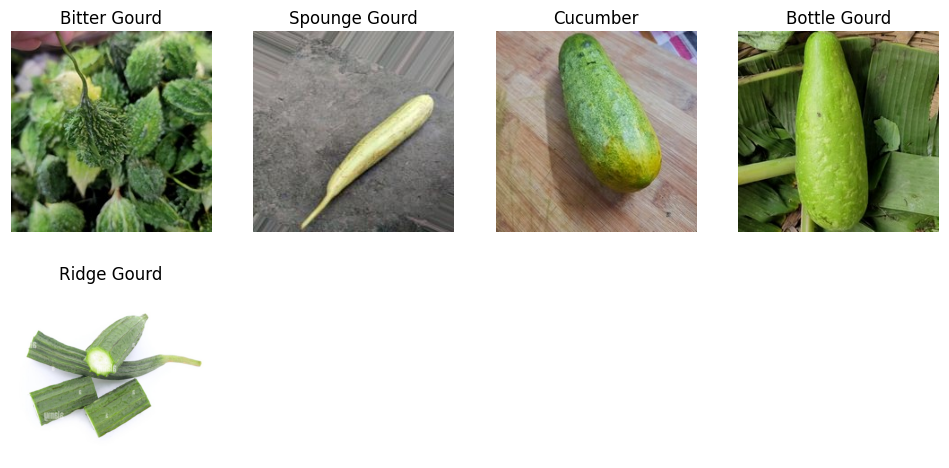

In [2]:
train_path="/kaggle/input/minor-gourd-cucumber-dataset/Train"
test_path="/kaggle/input/minor-gourd-cucumber-dataset/Test"
validation_path="/kaggle/input/minor-gourd-cucumber-dataset/Validation"

image_categories=os.listdir('/kaggle/input/minor-gourd-cucumber-dataset/Train')

def plot_images(image_categories):
    
    #create a figure
    plt.figure(figsize=(12,12))
    for i,cat in enumerate(image_categories):
        
        # Load images for the ith category
        image_path=train_path+'/'+cat
        images_in_folder=os.listdir(image_path)
        first_image_of_folder=images_in_folder[0]
        first_image_path=image_path+'/'+first_image_of_folder
        img=image.load_img(first_image_path)
        img_arr=image.img_to_array(img)/255.0
        
        
        #create subplot and plot the images
        plt.subplot(4,4,i+1)
        plt.imshow(img_arr)
        plt.title(cat)
        plt.axis('off')
        
    plt.show()
    

# call the function
plot_images(image_categories)

In [3]:
# creating image data generator for train,validation,test set

# 1.train set
train_gen=ImageDataGenerator(rescale=1.0/255.0) #normalise the data
train_image_generator=train_gen.flow_from_directory(
                                        train_path,
                                        target_size=(150,150),
                                        batch_size=32,
                                        class_mode='categorical')

# 2.validation set
val_gen=ImageDataGenerator(rescale=1.0/255.0) #normalise the data
val_image_generator=val_gen.flow_from_directory(
                                        validation_path,
                                        target_size=(150,150),
                                        batch_size=32,
                                        class_mode='categorical')

# 3.test set
test_gen=ImageDataGenerator(rescale=1.0/255.0)
test_image_generator=train_gen.flow_from_directory(
                                        test_path,
                                        target_size=(150,150),
                                        batch_size=32,
                                        class_mode='categorical')


Found 5000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [4]:
# build a custom model

model = keras.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3),strides=1,padding='same',activation='relu',input_shape=(150,150,3)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3),strides=1,padding='same',activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(5, activation='softmax')
])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,214,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,235,013 (42.86 MB)

 Trainable params: 11,235,013 (42.86 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# compile and fit the model
early_stopping=keras.callbacks.EarlyStopping(patience=5) # set up callbacks
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
hist=model.fit(train_image_generator,
              epochs=8,
              verbose=1,
              validation_data=val_image_generator,
              steps_per_epoch=5000//32,
              validation_steps=500//32,
              callbacks=early_stopping)

Epoch 1/8
156/156 ━━━━━━━━━━━━━━━━━━━━ 144s 882ms/step - accuracy: 0.8155 - loss: 0.5376 - val_accuracy: 0.8396 - val_loss: 0.4618
Epoch 2/8
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step - accuracy: 0.8750 - loss: 0.3280 - val_accuracy: 0.8000 - val_loss: 0.4123
Epoch 3/8


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


156/156 ━━━━━━━━━━━━━━━━━━━━ 132s 823ms/step - accuracy: 0.8994 - loss: 0.3128 - val_accuracy: 0.8854 - val_loss: 0.3676
Epoch 4/8
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 601us/step - accuracy: 0.8438 - loss: 0.3826 - val_accuracy: 0.8000 - val_loss: 0.8174
Epoch 5/8
156/156 ━━━━━━━━━━━━━━━━━━━━ 132s 825ms/step - accuracy: 0.9479 - loss: 0.1609 - val_accuracy: 0.9021 - val_loss: 0.3110
Epoch 6/8
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/step - accuracy: 0.9688 - loss: 0.1035 - val_accuracy: 0.9500 - val_loss: 0.0976
Epoch 7/8
156/156 ━━━━━━━━━━━━━━━━━━━━ 133s 820ms/step - accuracy: 0.9564 - loss: 0.1317 - val_accuracy: 0.9250 - val_loss: 0.2847
Epoch 8/8
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 864us/step - accuracy: 1.0000 - loss: 0.0484 - val_accuracy: 1.0000 - val_loss: 0.1470


In [13]:
# evaluation
# predict the accuracy for the test set
model.evaluate(test_image_generator)

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 543ms/step - accuracy: 0.9516 - loss: 0.1166


[0.1170886680483818, 0.9459999799728394]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


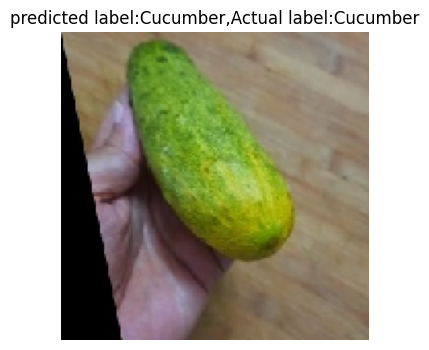

In [14]:
import numpy as np
# Testing the model
test_image_path='/kaggle/input/minor-gourd-cucumber-dataset/Test/Cucumber/Cucumber_1037.jpg'

# class_map = {v: k for k, v in train_gen.class_indices.items()}
class_map = {v: k for k, v in train_image_generator.class_indices.items()}


def generate_predictions(test_image_path,actual_label):

#     1. Load and preprocess the image.
    test_img=image.load_img(test_image_path,target_size=(150,150))
    test_img_arr=image.img_to_array(test_img)/255.0
    test_img_input=test_img_arr.reshape((1,test_img_arr.shape[0],test_img_arr.shape[1],test_img_arr.shape[2]))
    
#     2.make predictions
    predicted_label=np.argmax(model.predict(test_img_input))
    predicted_vegetable=class_map[predicted_label]
    plt.figure(figsize=(4,4))
    plt.imshow(test_img_arr)
    plt.title("predicted label:{},Actual label:{}".format(predicted_vegetable,actual_label))
    plt.grid()
    plt.axis('off')
    plt.show()
    

# call the function
generate_predictions(test_image_path,actual_label='Cucumber')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


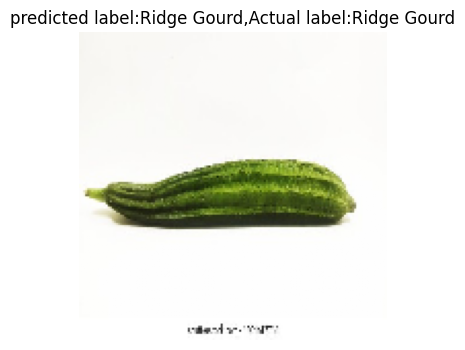

In [15]:
test_image_path='/kaggle/input/minor-gourd-cucumber-dataset/Test/Ridge Gourd/Ridge Gourd_1029.jpeg'
generate_predictions(test_image_path,actual_label='Ridge Gourd')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


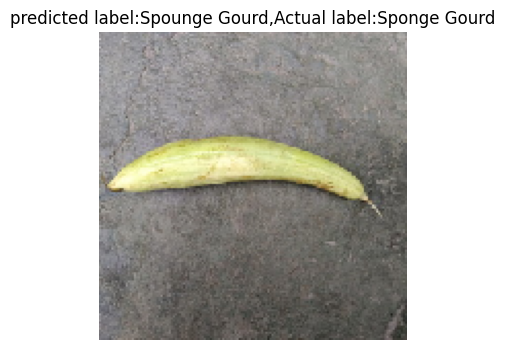

In [16]:
test_image_path='/kaggle/input/minor-gourd-cucumber-dataset/Test/Spounge Gourd/Spounge Gourd_1117.jpg'
generate_predictions(test_image_path,actual_label='Sponge Gourd')

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 526ms/step


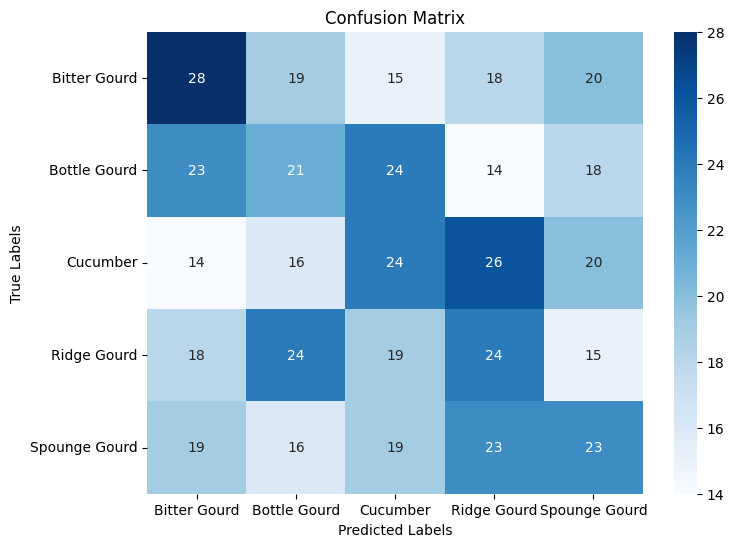

               precision    recall  f1-score   support

 Bitter Gourd       0.27      0.28      0.28       100
 Bottle Gourd       0.22      0.21      0.21       100
     Cucumber       0.24      0.24      0.24       100
  Ridge Gourd       0.23      0.24      0.23       100
Spounge Gourd       0.24      0.23      0.23       100

     accuracy                           0.24       500
    macro avg       0.24      0.24      0.24       500
 weighted avg       0.24      0.24      0.24       500



In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Predict on the test set
y_pred = model.predict(test_image_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels from the test generator
y_true = test_image_generator.classes

# 2. Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# 3. Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_image_generator.class_indices.keys(), yticklabels=test_image_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Optionally, print classification report
print(classification_report(y_true, y_pred_classes, target_names=test_image_generator.class_indices.keys()))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


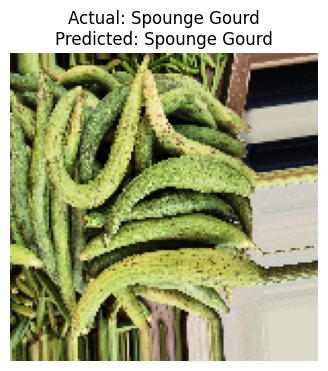

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


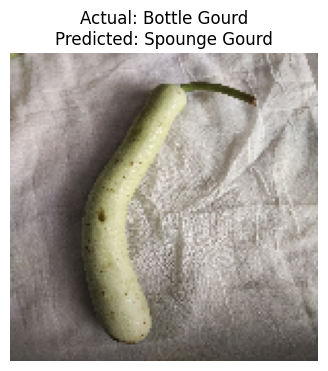

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


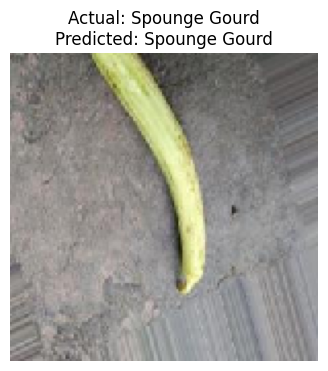

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


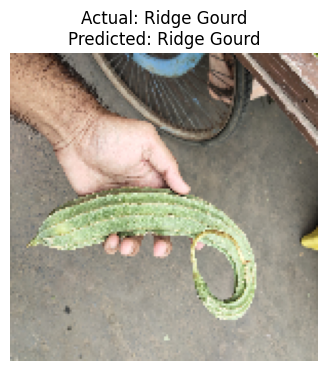

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


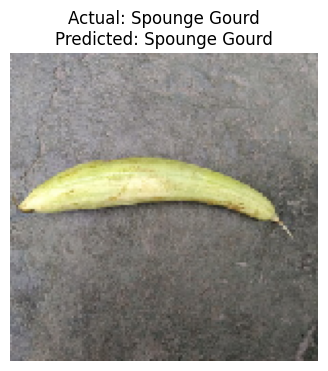

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


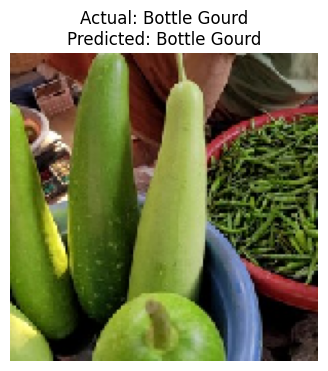

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


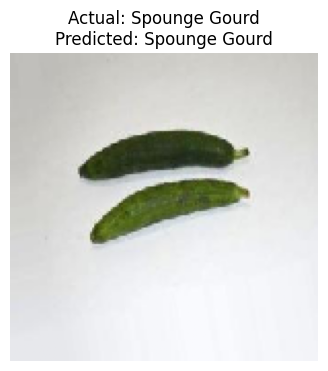

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


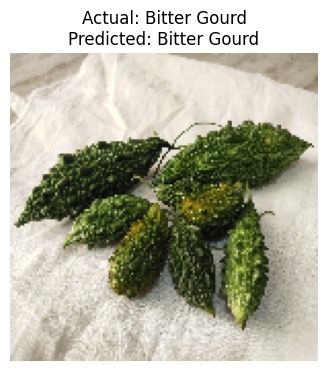

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


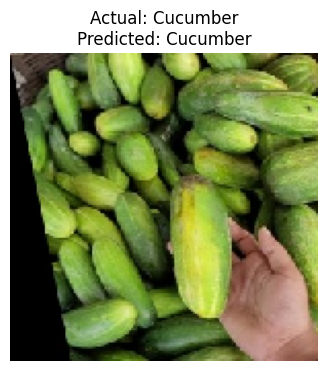

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


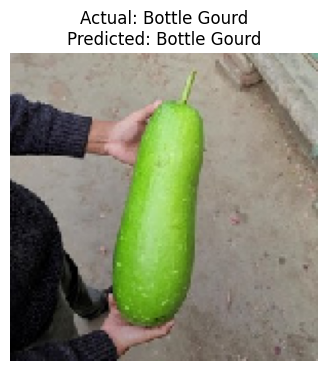

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


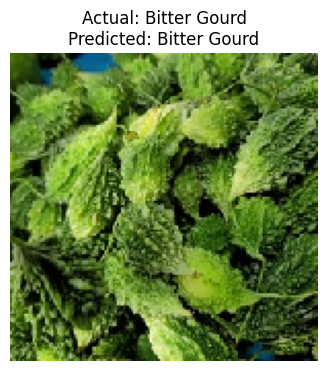

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


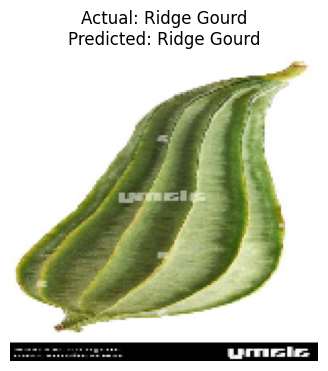

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


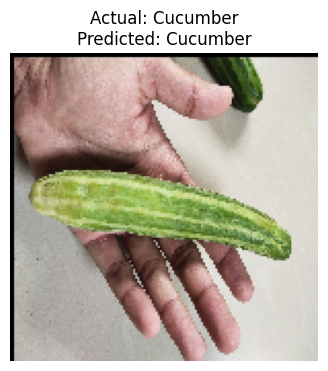

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


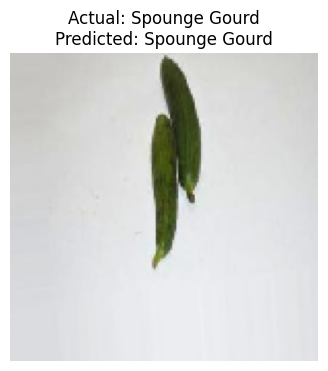

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


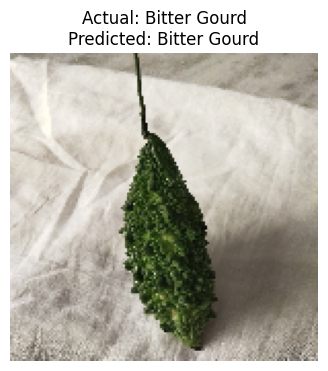

In [24]:
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Define the path for test set categories
test_image_categories = os.listdir(test_path)

# Function to randomly select and display an image, then show prediction
def check_random_prediction():
    # Select a random category from the test set
    random_category = random.choice(test_image_categories)
    
    # Select a random image from that category
    random_category_path = os.path.join(test_path, random_category)
    random_image_name = random.choice(os.listdir(random_category_path))
    random_image_path = os.path.join(random_category_path, random_image_name)
    
    # Load and preprocess the image
    img = image.load_img(random_image_path, target_size=(150, 150))
    img_arr = image.img_to_array(img) / 255.0
    img_input = img_arr.reshape((1, img_arr.shape[0], img_arr.shape[1], img_arr.shape[2]))
    
    # Predict the label of the image
    predicted_label_idx = np.argmax(model.predict(img_input))
    predicted_label = class_map[predicted_label_idx]
    
    # Show the image with actual and predicted labels
    plt.figure(figsize=(4, 4))
    plt.imshow(img_arr)
    plt.title(f"Actual: {random_category}\nPredicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Call the function
for i in range(0,15):
    check_random_prediction()


16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 583ms/step


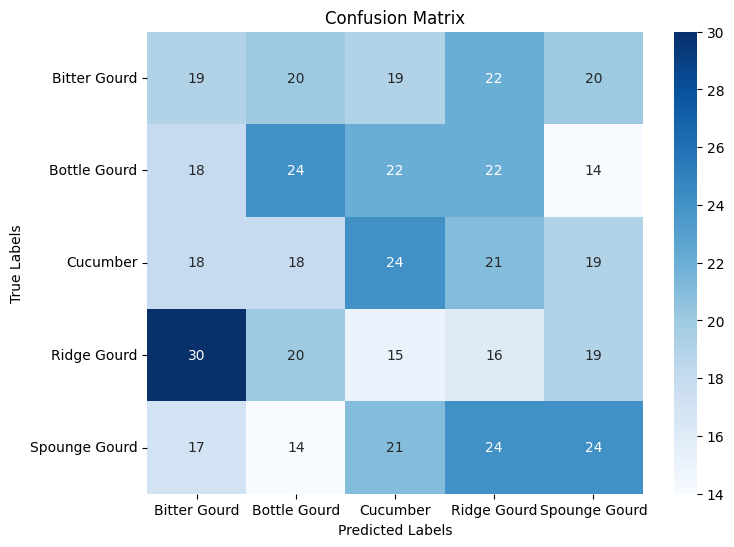

               precision    recall  f1-score   support

 Bitter Gourd       0.19      0.19      0.19       100
 Bottle Gourd       0.25      0.24      0.24       100
     Cucumber       0.24      0.24      0.24       100
  Ridge Gourd       0.15      0.16      0.16       100
Spounge Gourd       0.25      0.24      0.24       100

     accuracy                           0.21       500
    macro avg       0.22      0.21      0.21       500
 weighted avg       0.22      0.21      0.21       500



In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Get true and predicted labels for the test set
# Reset test generator to make predictions on the whole test set
test_image_generator.reset()

# Predict on the test set
y_pred = model.predict(test_image_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels from the test generator
y_true = test_image_generator.classes

# 2. Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# 3. Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_image_generator.class_indices.keys(), yticklabels=test_image_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Optionally, print classification report
print(classification_report(y_true, y_pred_classes, target_names=test_image_generator.class_indices.keys()))


## <center> Save the Model Architecture </center> 

In [20]:
model_json=model.to_json()
with open('classification.json','w') as f:
    f.write(model_json)
    
    
    
# print the architecture in string
print("model arch:",model_json)

model arch: {"module": "keras", "class_name": "Sequential", "config": {"name": "sequential_1", "trainable": true, "dtype": {"module": "keras", "class_name": "DTypePolicy", "config": {"name": "float32"}, "registered_name": null}, "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_shape": [null, 150, 150, 3], "dtype": "float32", "sparse": false, "name": "input_layer_1"}, "registered_name": null}, {"module": "keras.layers", "class_name": "Conv2D", "config": {"name": "conv2d_2", "trainable": true, "dtype": {"module": "keras", "class_name": "DTypePolicy", "config": {"name": "float32"}, "registered_name": null}, "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"module": "keras.initializers", "class_name": "GlorotUniform", "config": {"seed": null}, "registered_name": null}, "bias_initializer": {"module"

In [22]:
# Load the architecture from the JSON file
from tensorflow.keras.models import model_from_json

# Open and load the JSON file
with open('classification.json', 'r') as f:
    model_json = f.read()

# Load the architecture using model_from_json
model_architecture = model_from_json(model_json)
model_architecture.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,214,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,705,041 (128.57 MB)

 Trainable params: 11,235,013 (42.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,470,028 (85.72 MB)

## <center> Save weights of the model

In [25]:
model.save_weights('classification_weights.weights.h5')

# At a later point, we could then load the saved weights in to a new model, but the new model will need to have 
# the same architecture as the old model before the weights can be saved.

# first load the model architecture  or create same architecture for model2
model2.load_weights('classification_weights.weights.h5')

NameError: name 'model2' is not defined